# Tutorial: Sliding Window Analysis of Non-Linear Timeseries

This tutorial aims to show how regime shifts in non-linear timeseries with help of a sliding window recurrence analysis. The application of corresponding methods in the __pyunicorn__ package is illustrated with some examples.


## 1. Introduction

- Tutorial uses methods that are introduced in the RecurrenceNetwork and VisibilityGraph Tutorials.

### 1.1 The idea of a sliding window and what it is good for

- detecting regime shifts

### 1.2 Measures calculated

Within each of our sliding windows, we will calculate various measures that are briefly re-introduced in this section. For more extensive definitions see Marwan et al. (2021).

_Recurrence Plots_ show all points $i$ in a timeseries that recur at some other point $j$ in the timeseries. This way, we obtain the recurrence matrix $R_{ij}$. From a given recurrence plot, a histogram of diagonal line lengths $P(l)$ can be retrieved. The __determinism__ $DET$ of a timeseries is defined by the fraction of recurrence points that form diagonal lines of at least length $l_{min}$:

$$DET = \frac{\sum_{l=l_{min}}^N lP(l)}{\sum_{l=1}^N lP(l)}$$

Similarly, from the distribution of vertical line lengths, the timeseries' __laminarity__ $LAM$ can be calculated as

$$LAM = \frac{\sum_{v=v_{min}}^N vP(v)}{\sum_{v=1}^N vP(v)}$$

_Recurrence Networks_ can be created from recurrence plots. By identifying the recurrence matrix $R_{i,j}$ with the link matrix $A_{i,j}$ of a network, we can apply network measures to our timeseries. We subtract the identity line to exclude self-loops and obtain $A_{i,j} = R_{i,j} - \delta_{i,j}$ (with the Kronecker-Delta $\delta_{i,j}$). The __transitivity__  $\mathcal{T}$ of a network measures the probability that two neighbors (i.e. recurrences) of any state are also neighbors. It can be calculated as

$$\mathcal{T} = \frac{\sum_{i,j,k=1}^N A_{i,j}A_{j,k}A_{k,i}}{\sum_{i,j,k=1}^N A_{i,j}A_{k,i}}$$

From the pathlength $\ell$, the minimum number of links to cross to travel from one node to another, the __average path length__ $\mathcal{L}$ can be calculated

$$\mathcal{L} = \frac{1}{N(N-1)} \sum_{i,j=1}^N \ell_{i,j}$$ 

_Visibility Graphs (VG)_ are helpful to detect regime shifts by checking for irreversibility of a given phase space trajectory. If forward and backward (retarded and advanced) visibility links are equally distributed, the time series is reversible.

  - p(k)
  - p(C)


### Literature

- [Donges et al. (2011): Identification of dynamical transitions in marine palaeoclimate records by recurrence network analysis](https://doi.org/10.5194/npg-18-545-2011)

- [Donges et al. (2015): Non-linear regime shifts in Holocene Asian monsoon variability: potential impacts on cultural change and migratory patterns](https://doi.org/10.5194/cp-11-709-2015)

- [Marwan et al. (2021): Nonlinear time series analysis of palaeoclimate proxy records](https://doi.org/10.1016/j.quascirev.2021.107245)

## 2. Example: logistic map

First we import the necessary packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyunicorn.timeseries import RecurrenceNetwork, VisibilityGraph

We create a function to calculate a logistic map timeseries:

In [2]:
def logistic_map(x0, r, N, spinup=100):
    """
    Returns a time series of length T using the logistic map
    x_(n+1) = r*x_n(1-x_n) at parameter r and using the initial condition x0.

    INPUT: x0 - Initial condition, 0 <= x0 <= 1
            r - Bifurcation parameter, 0 <= r <= 4
            N - length of the desired time series
            spinup - number of spinup-timesteps before storing results to output
    OUTPUT: numpy array of timeseries under given parameters
    """
    # spinup
    for n in range(spinup):
        x0 = r * x0 * (1 - x0)

    #  Initialize timeSeries as python list with initial condition as first entry
    timeseries = [x0]

    for n in range(N):
        # get current timestep value
        xn = timeseries[n]
        # calculate next timestep value
        xstep = r * xn * (1 - xn)
        # append new timestep value to timeSeries
        timeseries.append(xstep)

    return np.array(timeseries)

Then we calculate an example timeseries with some interesting parameters

Text(0, 0.5, '$x_n$')

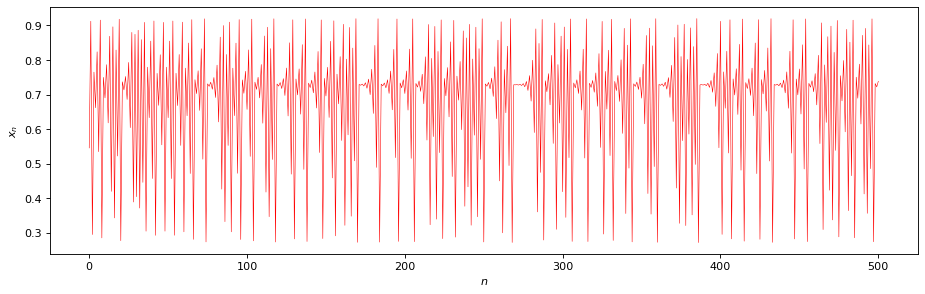

In [4]:
#  Parameters of logistic map
r = 3.679  # Bifurcation parameter
x0 = 0.7   # Initial value

#  Length of the time series
N = 500

#Generate the timeseries
x = logistic_map(x0, r, N)

#  Plot the time series
plt.figure(figsize=(14, 4), dpi=80)
plt.plot(x, "r", lw=.5)
plt.xlabel("$n$")
plt.ylabel("$x_n$")

In [ ]:
# Arrange the sliding windows
min_t = 0
max_t = N

win_size = 50 # window size for sliding windows
overlap = win_size/10 # overlap of sliding windows
win = np.arange(min_t ,max_t-win_size,overlap)
N = len(win) # number of sliding windows

# intitalize measure lists
w = []   # window center
DET = [] # determinism
LAM = [] # laminarity
T = []   # transitivity
L = []   # average path length
p_k = [] # VG measure
p_C = [] # VG measure


# Parameters

# Recurrence Plot
eps = 0.05
d = 1   # dimension of embedding
t = 0   # time delay

# Visibility Graph
#  Toggle calculation of horizontal visibility graphs (slower alternative are standard visibility graphs)
HORIZONTAL = True



In [ ]:
m = 0 # counter
for i in win:

    # Arranging the windowed time series
    x_win = x[i:i+win_size]

    # Recurrence Based Analysis
    net = RecurrenceNetwork(x_win,recurrence_rate=eps, silence_level=3, dim = d, tau=t)
    P_l_temp = net.diagline_dist()
    P_v_temp = net.vertline_dist()
    for j in range(len(P_l_temp)):
        P_l[j] += P_l_temp[j]
        P_v[j] += P_v_temp[j]
    P_order_temp = ntsa.symbolicPerm(x[y,1], d,t)
    P_order =  sorted(np.append(P_order, P_order_temp))

    # Visibility Graph
    vg = VisibilityGraph(time_series=x_win, horizontal=HORIZONTAL, silence_level=3)
    l_k_obs = vg.retarded_degree()
    r_k_obs = vg.advanced_degree()
    l_C_obs = vg.retarded_local_clustering()
    r_C_obs = vg.advanced_local_clustering()

    # store results
    w.append(i + win_size/2)
    T.append(net.transitivity())
    DET.append(net.determinism())
    LAM.append(net.laminarity())
    results[m,7] = net.average_path_length()    
    results[m,8] = scipy.stats.ks_2samp(l_k_obs, r_k_obs)[1]
    results[m,9] = scipy.stats.ks_2samp(l_C_obs, r_C_obs)[1]
    m += 1

## 3. Example: Lorenz attractor
- include time delay embedding

## 4. Example: Paleoclimate Record

- use ODP 659 (Atlantic Ocean offshore subtropical West Africa, SST and $\delta^{18}O$
- embedding more complicated due to irregular timesteps, see Marwan et al. 2021
